<h3> Submission

Proyek Akhir : Image Classification Model Deployment <br>
Nama: Delvin Fachrizky<h3>

In [1]:
"""
LIBRARY YANG DIGUNAKAN
"""
import os
import glob
import shutil
import zipfile
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from google.colab import files

In [2]:
"""
MENGEKSTRAK FOLDER ZIP DATASET YANG TELAH DIDOWNLOAD
"""
local_zip = '/content/drive/MyDrive/dicoding_dataset/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [24]:
"""
MENENTUKAN PATH UNTUK MASING-MASING DIRECTORY
"""
base_dir = '/content/dataset/dataset'
dir_rock = os.path.join(base_dir,'rock')
dir_paper = os.path.join(base_dir, 'paper')
dir_scissors = os.path.join(base_dir, 'scissors')

In [25]:
"""
MENGECEK JUMLAH DATA GAMBAR DARI DATASET
"""
total_img = len(list(glob.iglob("/content/dataset/dataset/*/*.*", recursive=True)))
print("Total Image\t\t  : ", total_img)

total_paper = len(os.listdir(dir_paper))
print("Total Data Paper Image\t  : ",total_paper)
total_rock = len(os.listdir(dir_rock))
print("Total Data Rock Image\t  : ",total_rock)
total_scissors = len(os.listdir(dir_scissors))
print("Total Data Scissors Image : ",total_scissors)

Total Image		  :  14600
Total Data Paper Image	  :  5696
Total Data Rock Image	  :  2904
Total Data Scissors Image :  6000


In [26]:
"""
PEMBUATAN TRAIN DAN VALIDATION DATA GENERATOR UNTUK AUGMENTASI DATA DENGAN VALUE SEBESAR 0.2 ATAU 20%
"""
Train_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = 0.2
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = 0.2
)

In [27]:
"""
MENGGUNAKAN MODE CATEOGRICAL UNTUK TRAIN DAN VALIDATION GENERATOR
"""
Train_generator = Train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = True,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = False,
    subset = "validation"
)

Found 11681 images belonging to 3 classes.
Found 2919 images belonging to 3 classes.


In [33]:
"""
SEQUENTIAL MODELING
"""
Model = Sequential(
    [
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu' , input_shape = (150,150,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(128, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),
     Dropout(0.2),
     Dense(128, activation = 'relu'),
     Dense(3, activation='softmax')
    ]
)

In [34]:
"""
ADAM OPTIMIZER DENGAN MENGGUNAKAN LEARNING RATE 0.00146
"""
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [35]:

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > 0.92):
			print("\n Accuracy is reaching > 92 and stopping the process")
			self.model.stop_training = True
 
callbacks = myCallback()

In [36]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

In [37]:
"""
TRANING
"""
batch_size = 16
with tf.device("/device:GPU:0"):
  history = Model.fit(Train_generator, 
                    epochs =  40, 
                    steps_per_epoch = 1751//batch_size, 
                    validation_data = Validation_generator, 
                    verbose = 1, 
                    validation_steps = 437//batch_size,
                    callbacks =[lr_schedule, callbacks])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
109/109 [==============================] - 84s 768ms/step - loss: 0.8727 - accuracy: 0.6135 - val_loss: 0.3803 - val_accuracy: 0.9282 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/40
109/109 [==============================] - 84s 768ms/step - loss: 0.4623 - accuracy: 0.8211 - val_loss: 0.6678 - val_accuracy: 0.7407 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/40
109/109 [==============================] - 82s 747ms/step - loss: 0.3099 - accuracy: 0.8945 - val_loss: 0.2212 - val_accuracy: 0.9306 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/40
109/109 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9295
 Accuracy is reaching > 92 and stopping the process
109/109 [==============================] - 83s 764ms/step 

Saving testt.png to testt.png


Hasil Prediksi :  [1. 0. 0.] 

Kategori Gambar : Paper


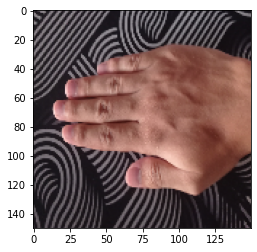

In [40]:
uploaded = files.upload()

for file_upload in uploaded.keys():

  path = file_upload
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = Model.predict(images, batch_size=16)
  
  print("\n")
  print('Hasil Prediksi : ',classes[0],'\n')

  if classes[0][0] == 1:
    print('Kategori Gambar : Paper')
  elif classes[0][1] == 1:
    print('Kategori Gambar : Rock')
  else:
    print('Kategori Gambar : Scissor')

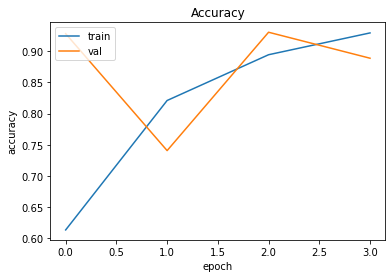

In [41]:
"""
MEMBUAT GRAFIK VISUALISASI DARI MODEL ACCURACY
"""
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

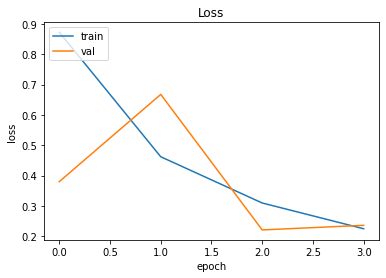

In [42]:
"""
MEMBUAT GRAFIK VISUALISASI DARI MODEL LOSS
"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
warnings.filterwarnings('ignore')

converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model_rps.tflite', 'wb') as f:
  f.write(tflite_model)